In [1]:
# Basic setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Mount Google Drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Walmart/train.csv')  # Update path if different
df.head()

Mounted at /content/drive


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [2]:
# Basic info
df.info()

# Summary statistics
df.describe()

# Check for missing values
df.isnull().sum()

# Convert date column
df['Date'] = pd.to_datetime(df['Date'])

# Preview by store
df['Store'].value_counts().head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


,count
Store,
13,10474
10,10315
4,10272
1,10244
2,10238


Plot overall sales trend

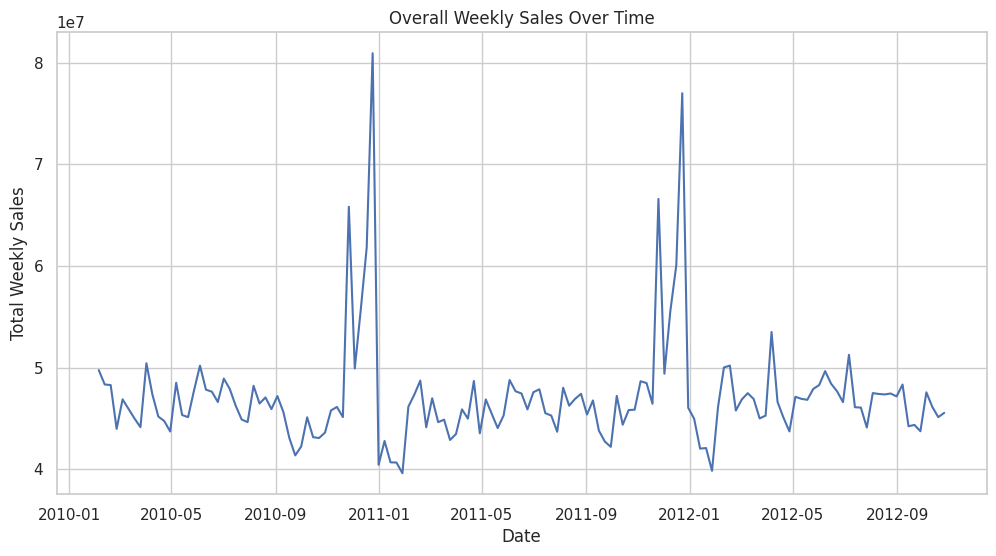

In [3]:
# Aggregate weekly sales
weekly_sales = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

# Plot
plt.plot(weekly_sales['Date'], weekly_sales['Weekly_Sales'])
plt.title("Overall Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")
plt.show()

Sales trend for a specific store

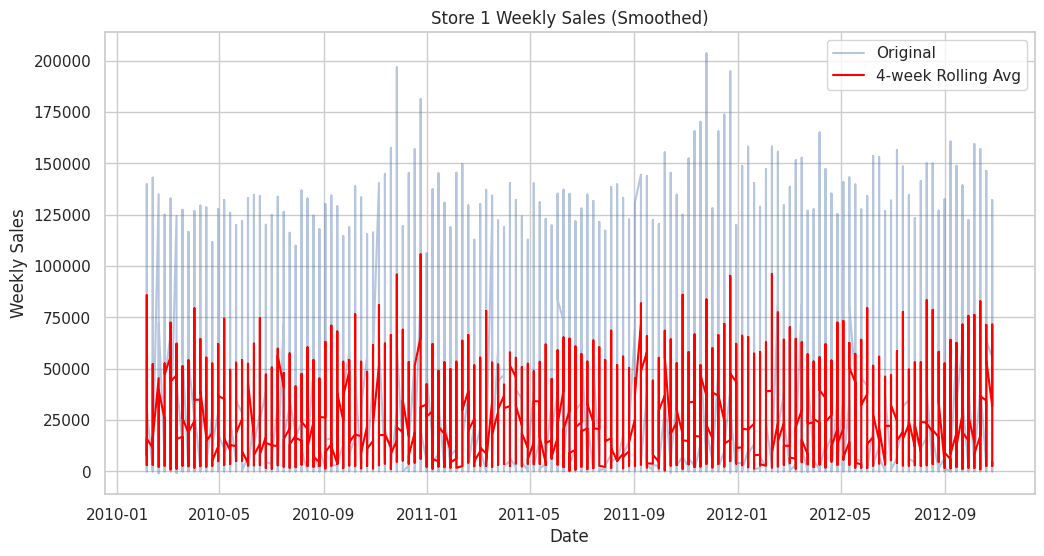

In [4]:
# Sort by date
store1 = df[df['Store'] == 1]

store1 = store1.sort_values('Date')

# Add rolling average (e.g., 4-week window)
store1['Rolling_Sales'] = store1['Weekly_Sales'].rolling(window=4).mean()

# Plot both raw and smoothed sales
plt.plot(store1['Date'], store1['Weekly_Sales'], alpha=0.4, label='Original')
plt.plot(store1['Date'], store1['Rolling_Sales'], color='red', label='4-week Rolling Avg')
plt.title("Store 1 Weekly Sales (Smoothed)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()

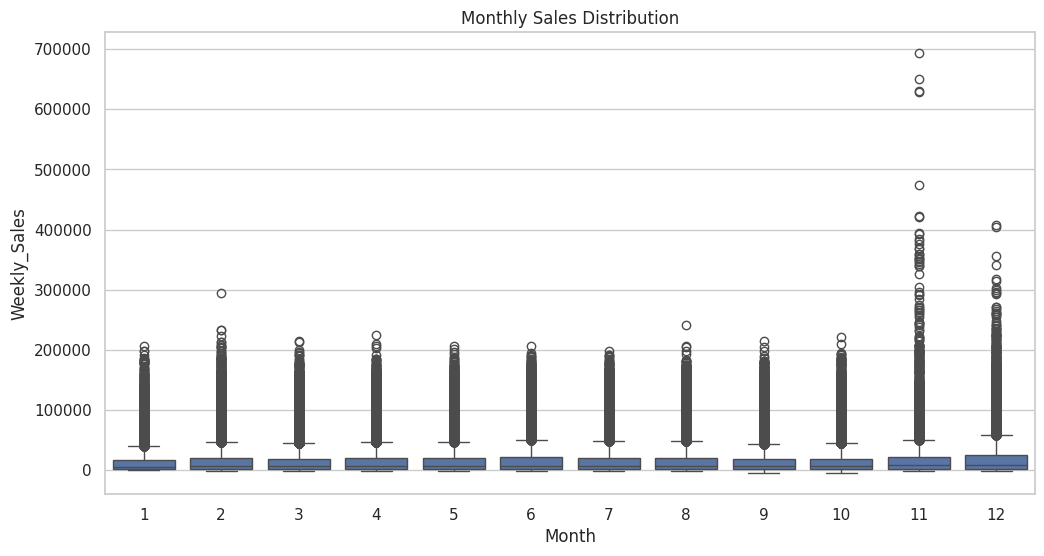

In [5]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Boxplot to see seasonal patterns
sns.boxplot(x='Month', y='Weekly_Sales', data=df)
plt.title("Monthly Sales Distribution")
plt.show()

In [6]:
store1 = store1.sort_values('Date')

In [7]:
store1_ts = store1.set_index('Date')

In [8]:
ts = store1_ts['Weekly_Sales']

In [9]:
ts_monthly = ts.resample('M').sum()

<ipython-input-9-3170d97ee233>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_monthly = ts.resample('M').sum()


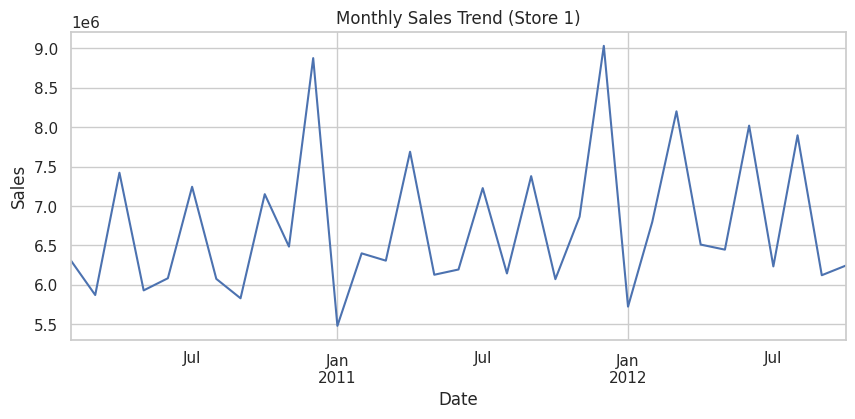

In [10]:
ts_monthly.plot(title='Monthly Sales Trend (Store 1)', figsize=(10, 4))
plt.ylabel("Sales")
plt.xlabel("Date")
plt.show()

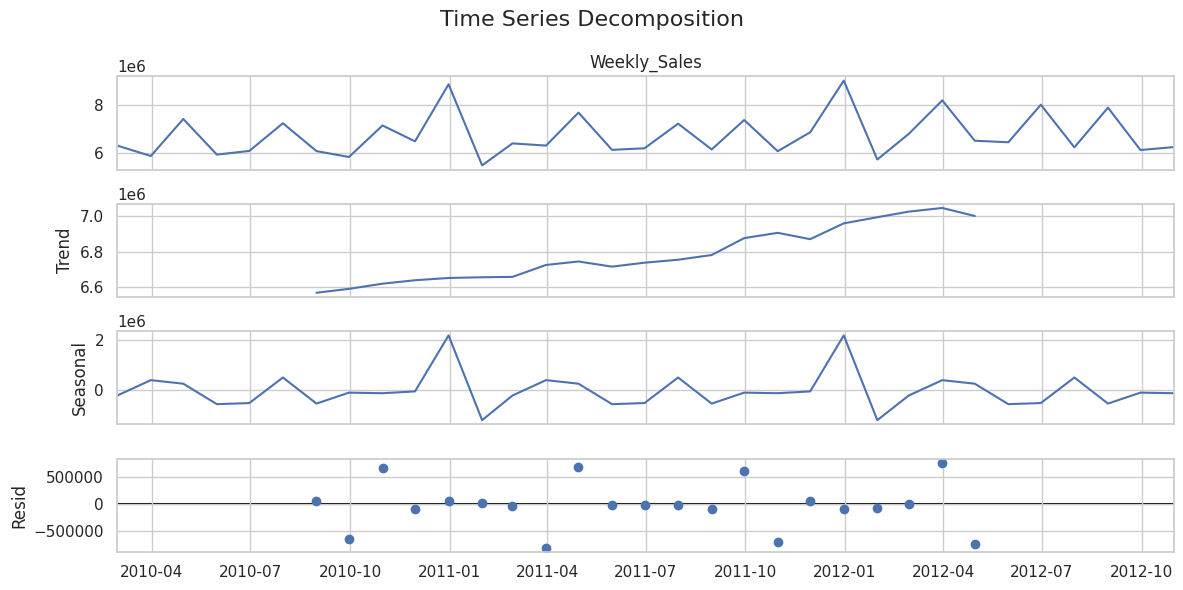

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the monthly time series
decomposition = seasonal_decompose(ts_monthly, model='additive')

# Plot the decomposed components
decomposition.plot()
plt.suptitle("Time Series Decomposition", fontsize=16)
plt.tight_layout()
plt.show()

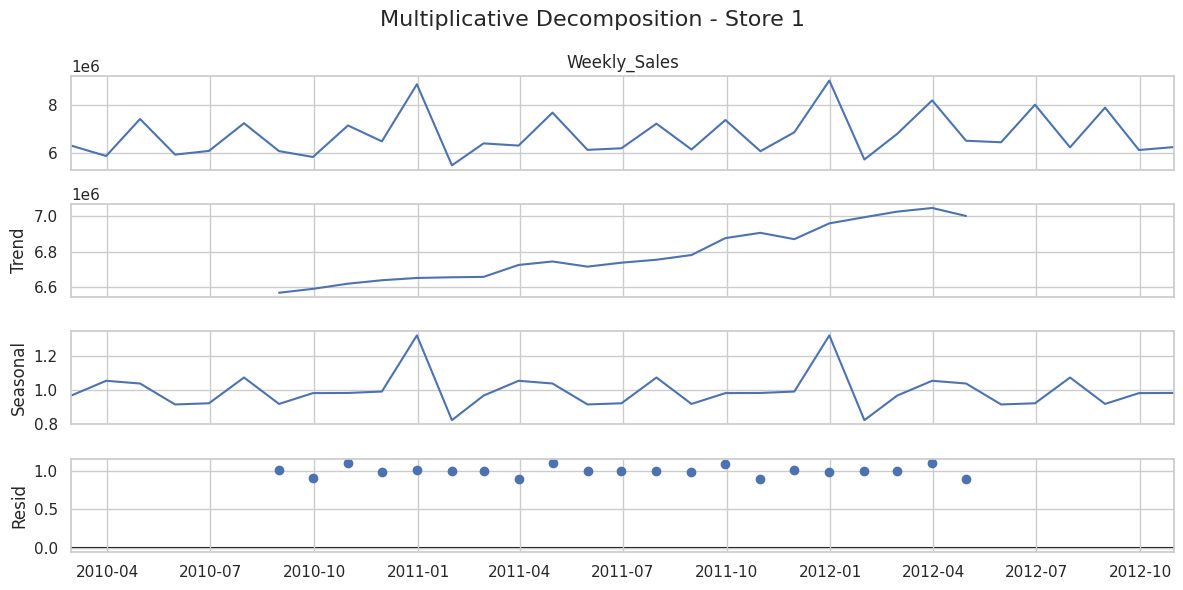

In [12]:
# Multiplicative model
decomposition_mul = seasonal_decompose(ts_monthly, model='multiplicative')

# Plot the decomposition
decomposition_mul.plot()
plt.suptitle("Multiplicative Decomposition - Store 1", fontsize=16)
plt.tight_layout()
plt.show()

In [13]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(ts_monthly.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")

ADF Statistic: -5.890717610882029
p-value: 2.9289087484822876e-07
Critical Value (1%): -3.661428725118324
Critical Value (5%): -2.960525341210433
Critical Value (10%): -2.6193188033298647


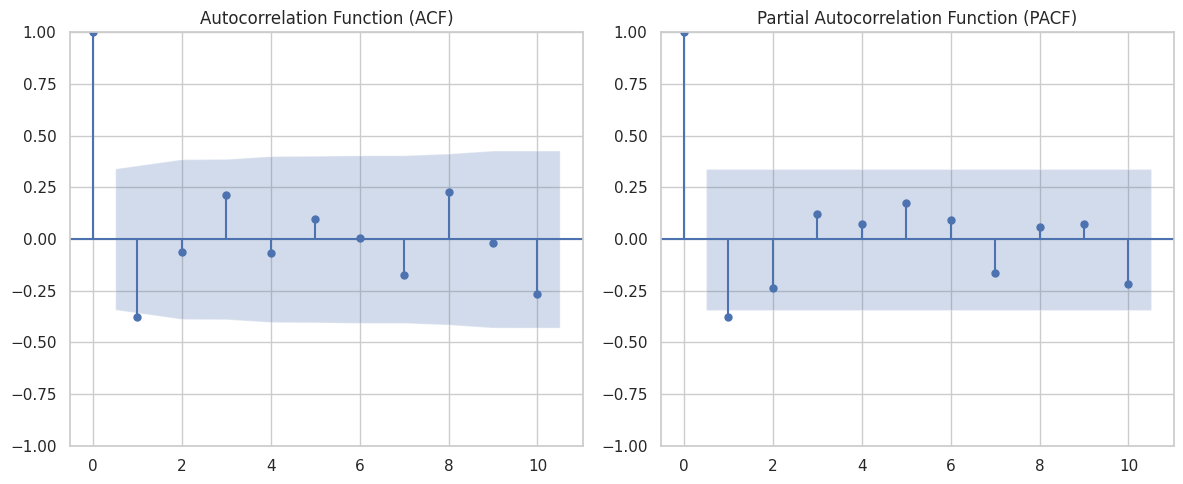

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Use a smaller lag value, e.g., 10
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(ts_monthly.dropna(), lags=10, ax=plt.gca())
plt.title("Autocorrelation Function (ACF)")

plt.subplot(1, 2, 2)
plot_pacf(ts_monthly.dropna(), lags=10, method='ywm', ax=plt.gca())
plt.title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

In [16]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA(1,1,1)
model = ARIMA(ts_monthly, order=(1, 1, 1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                   33
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -495.576
Date:                Wed, 28 May 2025   AIC                            997.152
Time:                        01:11:00   BIC                           1001.550
Sample:                    02-28-2010   HQIC                           998.610
                         - 10-31-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0975      0.132     -0.740      0.459      -0.356       0.161
ma.L1         -0.6148      0.146     -4.214      0.000      -0.901      -0.329
sigma2      9.712e+11   1.58e-14   6.13e+25      0.0

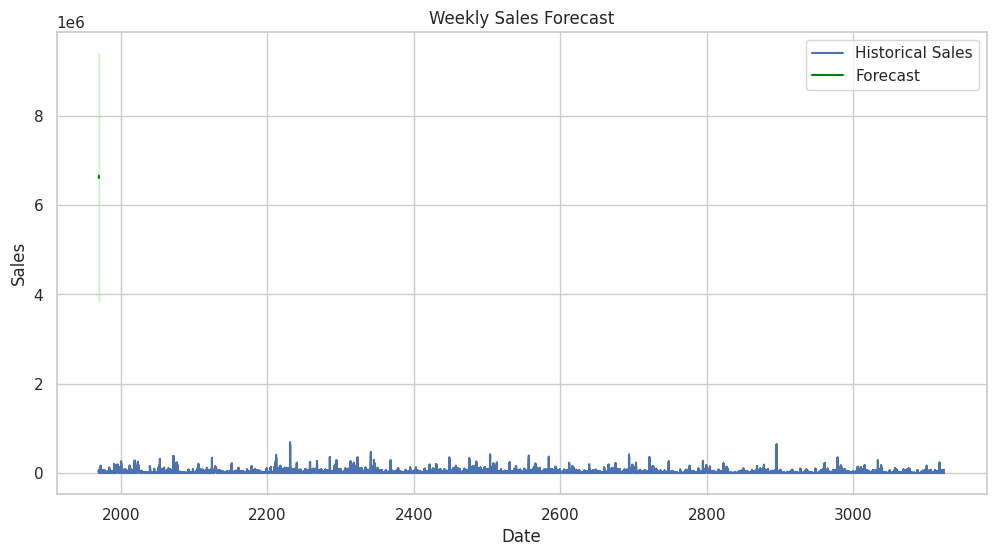

In [17]:
# Forecast 10 future weeks
forecast_steps = 10
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot actual and forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Weekly_Sales'], label='Historical Sales')
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='W')[1:]
plt.plot(forecast_index, forecast_mean, label='Forecast', color='green')
plt.fill_between(forecast_index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='lightgreen', alpha=0.5)
plt.title('Weekly Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

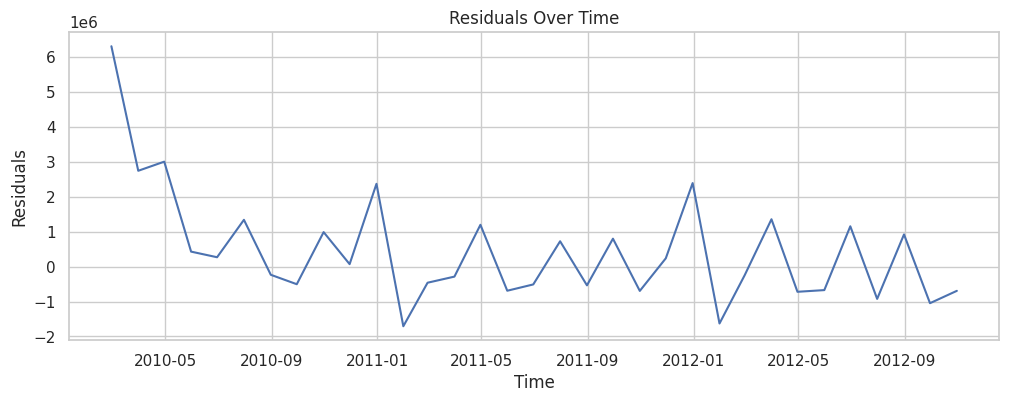

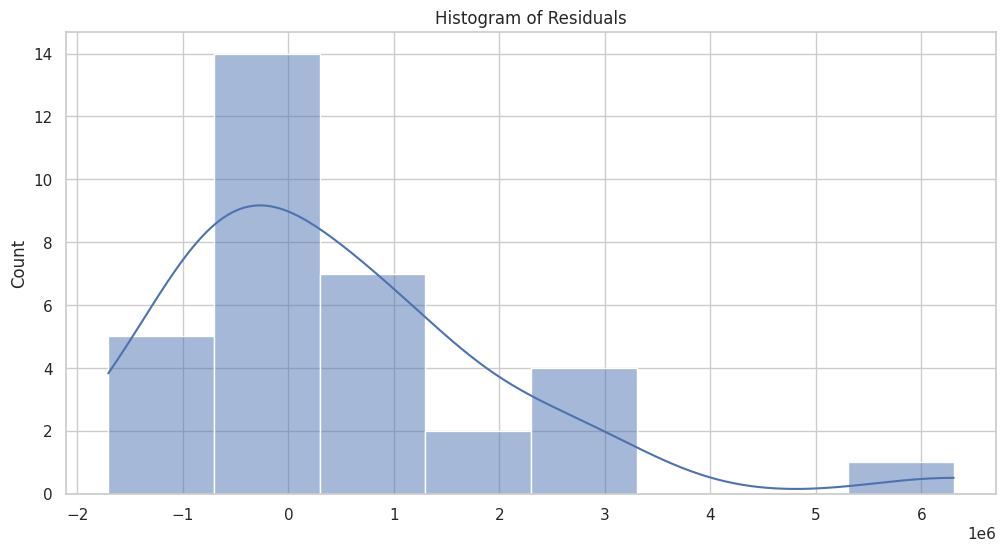

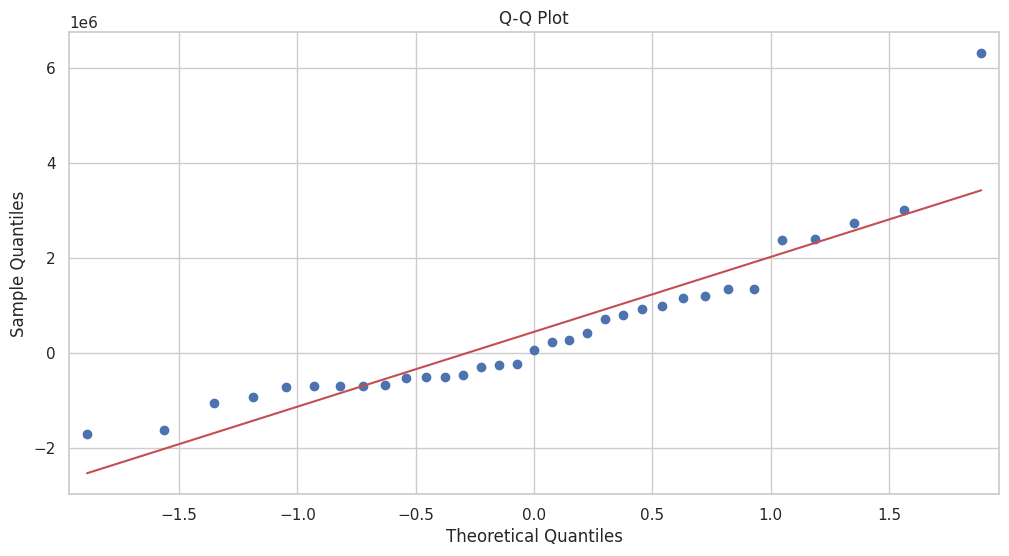

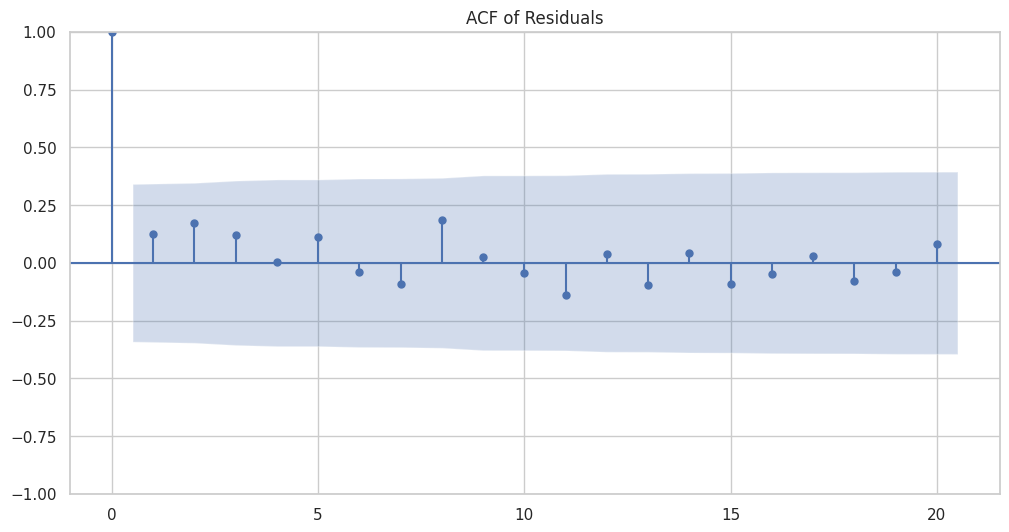

     lb_stat  lb_pvalue
10  4.832056   0.902111


In [18]:
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox

# Residuals
residuals = model_fit.resid

# 1. Residual Plot
plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

# 2. Histogram and Density Plot
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()

# 3. Q-Q Plot for Normality Check
qqplot(residuals, line='s')
plt.title("Q-Q Plot")
plt.show()

# 4. ACF Plot of Residuals (to check for autocorrelation)
plot_acf(residuals, lags=20)
plt.title("ACF of Residuals")
plt.show()

# 5. Ljung-Box test for autocorrelation
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)